<img src="https://raw.githubusercontent.com/iterative/datachain/main/docs/assets/datachain-white.svg" alt="Dataset" style="width: 200px;"/>

# Tutorial: Enhancing Video Dataset and Frame-Level Annotation Management for YOLOv8 Pose Detection projects

This tutorial dives into techniques to manage video and image datasets for Video Analytics and Vision AI projects. 

**📋 Topics covered:**
1. Building a Video DataChain for `kinetics-700-2020` video dataset
2. Creating a Data Model for YOLOv8 Pose Detection projects
3. Integrating Video-Level Annotations from CSV
5. Extract and Manage Video Frames
6. Running Pose Detection with YOLOv8 and Saving to DataChain
7. Visualizing Pose Data

# 🆕 Building a Video DataChain for `kinetics-700-2020` video dataset

Note: only `validation` split is used for the example purposes

In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

from datachain import DataChain, C

## Create a DataChain from a S3 bucket

In [2]:
# # Create a DataChain from previously save dataset

# ds = (
#     DataChain.from_dataset("kinetics-700-2020-val")
# )

# ds.show(3)

## Create a DataChain from a local directory of videos

**(OPTIONAL) You may skip this and work with data in our public dataset.**

- Download the `kinetics-700-2020` dataset 
- Unzip data into `examples/kinetics_actions_video/data` directory 


In [2]:
# Create a DataChain

DATA_PATH = "k700-2020/val/"

video_dc = (
    DataChain.from_storage(DATA_PATH, type='image')
    .filter(C("file.path").glob("*.mp4"))
)
video_dc.show(3)

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processed: 1 rows [00:00, 308.20 rows/s]
Generated: 3 rows [00:00, 1546.19 rows/s]
Cleanup: 1 tables [00:00, 2172.09 tables/s]
Listing file:///: 34666 objects [00:01, 25586.98 objects/s]
Processed: 1 rows [00:04,  4.79s/ rows]
Generated: 33966 rows [00:03, 9911.38 rows/s]
Saving: 33966 rows [00:01, 33086.32 rows/s]
Cleanup: 1 tables [00:00,  7.50 tables/s]


file                                               file     file  \
     source                                               path     size   
0  file:///  workspaces/datachain-examples/computer_vision/...  2109031   
1  file:///  workspaces/datachain-examples/computer_vision/...   930580   
2  file:///  workspaces/datachain-examples/computer_vision/...  2754196   

     file                   file      file                      file     file  
  version                   etag is_latest             last_modified location  
0          0x1.7f359f9800000p+30         1 2020-12-06 23:23:18+00:00     None  
1          0x1.7f359f9c00000p+30         1 2020-12-06 23:23:19+00:00     None  
2          0x1.7f359f9c00000p+30         1 2020-12-06 23:23:19+00:00     None


[Limited by 3 rows]


# Creating a Data Model for YOLOv8 Pose Detection projects

In [3]:
from datachain import DataModel
from pydantic import Field


class Video(DataModel):
    video_id: str
    duration: float
    width: int
    height: int
    fps: float
    frame_count: int
    codec: int

class Frame(DataModel):
    video_id: str
    frame_id: str
    width: int
    height: int


class BBox(DataModel):
    x1: float = 0.0
    y1: float = 0.0
    x2: float = 0.0
    y2: float = 0.0
    
class Keypoints(DataModel):
    x: list[float] = []
    y: list[float] = []
    visible: list[float] = []

class Detection(DataModel):
    name: str = ""
    cls: int = Field(99999, alias='class')
    confidence: float = 0.0
    boxes: BBox = Field(default_factory=BBox, alias='box')
    keypoints: Keypoints = Field(default_factory=Keypoints)
    orig_shape: list[int] = []
    is_detected: bool = False

    class Config:
        populate_by_name = True
        from_attributes = True

# Integrating Video-Level Annotations from CSV

Many datasets come with pre-existing annotations in CSV format. Here's how to integrate them seamlessly:

CSV Parsing: Implement robust CSV parsing with error handling.
Mapping: Create a mapping between CSV fields and your data model.
Validation: Implement checks to ensure data integrity during import.

## Add Video metadata

In [4]:
from src.video_utils import get_video_metadata

def add_video_metadata(file) -> Video: 
    video_id = file.get_file_stem().split('_')[0]
    metadata = get_video_metadata(file.get_path())
    return Video(video_id=video_id, **metadata)
    

video_dc = video_dc.map(video=lambda file: add_video_metadata(file), output={'video': Video})
video_dc.show(3)

Preparing: 33966 rows [00:00, 36561.17 rows/s]
Processed: 33966 rows [05:01, 112.57 rows/s]
Cleanup: 2 tables [00:00, 11.84 tables/s]


file                                               file     file  \
     source                                               path     size   
0  file:///  workspaces/datachain-examples/computer_vision/...  2109031   
1  file:///  workspaces/datachain-examples/computer_vision/...   930580   
2  file:///  workspaces/datachain-examples/computer_vision/...  2754196   

     file                   file      file                      file     file  \
  version                   etag is_latest             last_modified location   
0          0x1.7f359f9800000p+30         1 2020-12-06 23:23:18+00:00     None   
1          0x1.7f359f9c00000p+30         1 2020-12-06 23:23:19+00:00     None   
2          0x1.7f359f9c00000p+30         1 2020-12-06 23:23:19+00:00     None   

         video    video video  video     video       video      video  
      video_id duration width height       fps frame_count      codec  
0  3fNbYkV8Mlc   6.2062  1280    720  29.97003         186  875967080  
1  -qK-i0M1e1A  10.0000   640    360  30.00000         300  875967080  
2  vOHuwzAUWOo  10.0000  1280    720  30.00000         300  875967080


[Limited by 3 rows]


## Create Video Labels DataChain

In [5]:
# Video annotations 
video_labels_path = "k700-2020/annotations/val.csv"


k700_dc = (
    DataChain.from_csv(os.path.abspath(video_labels_path))
    .select_except("source")
    .save()
)

print(k700_dc.count())
k700_dc.show(3)

Processed: 1 rows [00:00, 334.05 rows/s]
Generated: 4 rows [00:00, 2114.06 rows/s]
Cleanup: 1 tables [00:00, 2385.84 tables/s]
Listing file:///: 35 objects [00:00, 12018.06 objects/s]
Processed: 1 rows [00:00, 68.62 rows/s]
Generated: 28 rows [00:00, 7634.43 rows/s]
Saving: 28 rows [00:00, 14489.88 rows/s]
Cleanup: 1 tables [00:00, 3412.78 tables/s]
Processed: 0 rows [00:00, ? rows/s]













Parsed by pyarrow: 33966 rows [00:03, 9793.82 rows/s]
Processed: 1 rows [00:03,  3.76s/ rows]
Generated: 33966 rows [00:03, 9277.86 rows/s]
Saving: 33966 rows [00:00, 39912.64 rows/s]
Cleanup: 1 tables [00:00,  6.93 tables/s]

33966


label   youtube_id  time_start  time_end     split
0  abseiling  hY_WBLs6ShA          16        26  validate
1  abseiling  WVTRUmNU8rA         214       224  validate
2  abseiling  TI7DfPMNBPM          21        31  validate


[Limited by 3 rows]


## Add Annotations to Video Dataset

In [6]:
# Add annotations to Dataset

dc = (
    video_dc
    .merge(k700_dc, on="video.video_id", right_on="youtube_id", inner=True)
    .save("k700-val")
)

print(dc.count())
dc.show(3)

Preparing: 0 rows [00:00, ? rows/s]

Preparing: 33966 rows [00:00, 36457.64 rows/s]
Processed: 33966 rows [04:10, 135.35 rows/s]
Saving: 29487 rows [00:01, 21091.25 rows/s]
Cleanup: 8 tables [00:00, 47.82 tables/s]

29487


file                                               file     file  \
     source                                               path     size   
0  file:///  workspaces/datachain-examples/computer_vision/...  2109031   
1  file:///  workspaces/datachain-examples/computer_vision/...   930580   
2  file:///  workspaces/datachain-examples/computer_vision/...  2754196   

     file                   file      file                      file     file  \
  version                   etag is_latest             last_modified location   
0          0x1.7f359f9800000p+30         1 2020-12-06 23:23:18+00:00     None   
1          0x1.7f359f9c00000p+30         1 2020-12-06 23:23:19+00:00     None   
2          0x1.7f359f9c00000p+30         1 2020-12-06 23:23:19+00:00     None   

         video    video video  video     video       video      video  \
      video_id duration width height       fps frame_count      codec   
0  3fNbYkV8Mlc   6.2062  1280    720  29.97003         186  875967080   
1  -qK-i0M1e1A  10.0000   640    360  30.00000         300  875967080   
2  vOHuwzAUWOo  10.0000  1280    720  30.00000         300  875967080   

          label   youtube_id time_start time_end     split  
                                                            
0  spinning poi  3fNbYkV8Mlc        202      212  validate  
1  spinning poi  -qK-i0M1e1A          0       10  validate  
2  spinning poi  vOHuwzAUWOo         92      102  validate


[Limited by 3 rows]


In [11]:
dc.schema

{'file': datachain.lib.file.ImageFile,
 'video': __main__.Video,
 'label': typing.Optional[str],
 'youtube_id': typing.Optional[str],
 'time_start': typing.Optional[int],
 'time_end': typing.Optional[int],
 'split': typing.Optional[str]}

# Build a dataset for top activities

Let's say we want to reduce activities to a list of the most frequent one.

In [8]:
top_activities = ['cheerleading', 'capoeira', 'sword fighting', 'lawn mower racing',
       'high jump', 'tackling', 'dodgeball', 'walking on stilts',
       'skiing slalom', 'hurdling', 'running on treadmill', 'playing polo',
       'pull ups', 'wrestling', 'battle rope training', 'exercising arm',
]


dc_top = (
    DataChain.from_dataset('k700-val')
    .filter(C('label').in_(top_activities))
    .save("k700-top-videos")
)
print(dc_top.count())
dc_top.show(10)

Saving: 702 rows [00:00, 43564.61 rows/s]

702


file                                               file     file  \
     source                                               path     size   
0  file:///  workspaces/datachain-examples/computer_vision/...   763916   
1  file:///  workspaces/datachain-examples/computer_vision/...    73721   
2  file:///  workspaces/datachain-examples/computer_vision/...   866846   
3  file:///  workspaces/datachain-examples/computer_vision/...   717155   
4  file:///  workspaces/datachain-examples/computer_vision/...   627820   
5  file:///  workspaces/datachain-examples/computer_vision/...   565246   
6  file:///  workspaces/datachain-examples/computer_vision/...  1416010   
7  file:///  workspaces/datachain-examples/computer_vision/...  1001227   
8  file:///  workspaces/datachain-examples/computer_vision/...   764302   
9  file:///  workspaces/datachain-examples/computer_vision/...  3674421   

     file                   file      file                      file     file  \
  version                   etag is_latest             last_modified location   
0          0x1.7f359dd000000p+30         1 2020-12-06 23:21:24+00:00     None   
1          0x1.7f359ddc00000p+30         1 2020-12-06 23:21:27+00:00     None   
2          0x1.7f359dd000000p+30         1 2020-12-06 23:21:24+00:00     None   
3          0x1.7f359dd000000p+30         1 2020-12-06 23:21:24+00:00     None   
4          0x1.7f359dd800000p+30         1 2020-12-06 23:21:26+00:00     None   
5          0x1.7f359dd000000p+30         1 2020-12-06 23:21:24+00:00     None   
6          0x1.7f359dd000000p+30         1 2020-12-06 23:21:24+00:00     None   
7          0x1.7f359dd400000p+30         1 2020-12-06 23:21:25+00:00     None   
8          0x1.7f359dd400000p+30         1 2020-12-06 23:21:25+00:00     None   
9          0x1.7f359dd800000p+30         1 2020-12-06 23:21:26+00:00     None   

         video      video video  video     video       video      video  \
      video_id   duration width height       fps frame_count      codec   
0  g8qIgXEm5Hg  10.000000   352    288  15.00000         150  875967080   
1  eC5gnQobNrU   5.305300   480    360  29.97003         159  875967080   
2  EXiuMp0OOIE   9.440000   640    360  25.00000         236  875967080   
3  gd1vulHXBMU  10.000000   320    240  15.00000         150  875967080   
4  FrrQoyxOz5s  10.010000   352    240  29.97003         300  875967080   
5  ghtF8Iof6VU  10.022049   320    240  19.95600         200  875967080   
6  E7Iewots4xQ  10.000000   480    360  30.00000         300  875967080   
7  dPtwKAC7TUI  10.000000   638    360  25.00000         250  875967080   
8  GRWjtpd46-o  10.010000   448    336  29.97003         300  875967080   
9  CEVO0nClDTY  10.010000  1280    720  29.97003         300  875967080   

      label   youtube_id time_start time_end     split  
                                                        
0  capoeira  g8qIgXEm5Hg         52       62  validate  
1  capoeira  eC5gnQobNrU         75       85  validate  
2  capoeira  EXiuMp0OOIE         26       36  validate  
3  capoeira  gd1vulHXBMU        103      113  validate  
4  capoeira  FrrQoyxOz5s         22       32  validate  
5  capoeira  ghtF8Iof6VU          0       10  validate  
6  capoeira  E7Iewots4xQ         55       65  validate  
7  capoeira  dPtwKAC7TUI          2       12  validate  
8  capoeira  GRWjtpd46-o         33       43  validate  
9  capoeira  CEVO0nClDTY         77       87  validate


[Limited by 10 rows]


## Preview a file example

In [9]:
sample_results = list(dc_top.distinct('file.path').limit(10).collect())
example = sample_results[1]
example

(ImageFile(source='file:///', path='workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/ADtYZmfgeSM_000102_000112.mp4', size=2262926, version='', etag='0x1.7f3597f000000p+30', is_latest=True, last_modified=datetime.datetime(2020, 12, 6, 23, 15, 8, tzinfo=datetime.timezone.utc), location=None),
 Video(video_id='ADtYZmfgeSM', duration=9.542866666666667, width=1280, height=720, fps=29.97002997002997, frame_count=286, codec=875967080),
 'battle rope training',
 'ADtYZmfgeSM',
 102,
 112,
 'validate')

In [10]:
from IPython.display import Video

video_path = example[0].get_path()
Video(video_path, width=640, height=360, embed=True)

## Preview a schema

In [11]:
# Signals schema

dc_top.schema

{'file': datachain.lib.file.ImageFile,
 'video': __main__.Video,
 'label': typing.Optional[str],
 'youtube_id': typing.Optional[str],
 'time_start': typing.Optional[int],
 'time_end': typing.Optional[int],
 'split': typing.Optional[str]}

In [13]:
# File signals schema

dc_top.schema['file'].model_json_schema()

{'description': '`DataModel` for reading image files.',
 'properties': {'source': {'default': '', 'title': 'Source', 'type': 'string'},
  'path': {'title': 'Path', 'type': 'string'},
  'size': {'default': 0, 'title': 'Size', 'type': 'integer'},
  'version': {'default': '', 'title': 'Version', 'type': 'string'},
  'etag': {'default': '', 'title': 'Etag', 'type': 'string'},
  'is_latest': {'default': True, 'title': 'Is Latest', 'type': 'boolean'},
  'last_modified': {'default': '1970-01-01T00:00:00Z',
   'format': 'date-time',
   'title': 'Last Modified',
   'type': 'string'},
  'location': {'anyOf': [{'type': 'object'},
    {'items': {'type': 'object'}, 'type': 'array'},
    {'type': 'null'}],
   'default': None,
   'title': 'Location'}},
 'required': ['path'],
 'title': 'ImageFile',
 'type': 'object'}

# Extract and Manage Video Frames

In [14]:
from tqdm import tqdm 

from src.video_utils import split_video_to_frames

## Extract Video Frames

Let's extract every 5th frame videos and save to `data/frames` subdir 

In [15]:
dc_top = DataChain.from_dataset('k700-top-videos')


for file in tqdm(list(dc_top.distinct('file.path').limit(10).collect())):

    video_path = file[0].get_path()
    
    split_video_to_frames(
        video_path, 
        output_dir='data/frames', 
        step=5, # save every 5th frame 
        rewrite=True
    )

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:04,  1.95it/s]

Saved 60 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/9Ohpl6l4gEI_000072_000082.mp4 to data/frames/9Ohpl6l4gEI


 20%|██        | 2/10 [00:00<00:03,  2.20it/s]

Saved 58 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/ADtYZmfgeSM_000102_000112.mp4 to data/frames/ADtYZmfgeSM


 30%|███       | 3/10 [00:01<00:02,  2.38it/s]

Saved 60 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/AIF4DmpgrtI_000000_000010.mp4 to data/frames/AIF4DmpgrtI
Saved 56 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/ANwVUvD712A_000022_000032.mp4 to data/frames/ANwVUvD712A


 60%|██████    | 6/10 [00:01<00:01,  3.96it/s]

Saved 56 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/AUg1Thvho14_000049_000059.mp4 to data/frames/AUg1Thvho14
Saved 60 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/AYF9WardS9M_000002_000012.mp4 to data/frames/AYF9WardS9M
Saved 60 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/AeQvqXzXZCM_000015_000025.mp4 to data/frames/AeQvqXzXZCM


 80%|████████  | 8/10 [00:02<00:00,  5.82it/s]

Saved 60 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/AeWHzF-65k4_000001_000011.mp4 to data/frames/AeWHzF-65k4
Saved 60 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/AtEODzq0S6A_000037_000047.mp4 to data/frames/AtEODzq0S6A


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

Saved 60 frames from //workspaces/datachain-examples/computer_vision/video_pose_detection_yolov8/k700-2020/val/battle rope training/Auf6zunrY5s_000001_000011.mp4 to data/frames/Auf6zunrY5s


## Create a Frame DataChain

In [17]:
# Create DataChain for frames

frame_dc = (
    DataChain.from_storage('data/frames', type='image')
    .filter(C("file.path").glob("*.jpg"))
)
frame_dc.show(10)

Processed: 1 rows [00:00, 341.67 rows/s]
Generated: 6 rows [00:00, 2838.46 rows/s]
Cleanup: 1 tables [00:00, 3358.13 tables/s]


file                                               file    file  \
     source                                               path    size   
0  file:///  workspaces/datachain-examples/computer_vision/...  208358   
1  file:///  workspaces/datachain-examples/computer_vision/...  211514   
2  file:///  workspaces/datachain-examples/computer_vision/...  209953   
3  file:///  workspaces/datachain-examples/computer_vision/...   19040   
4  file:///  workspaces/datachain-examples/computer_vision/...  186477   
5  file:///  workspaces/datachain-examples/computer_vision/...   42824   
6  file:///  workspaces/datachain-examples/computer_vision/...  113275   
7  file:///  workspaces/datachain-examples/computer_vision/...   18882   
8  file:///  workspaces/datachain-examples/computer_vision/...  211912   
9  file:///  workspaces/datachain-examples/computer_vision/...   18224   

     file                   file      file                             file  \
  version                   etag is_latest                    last_modified   
0          0x1.9b98f0842aa85p+30         1 2024-09-15 01:45:05.041658+00:00   
1          0x1.9b98f083f568dp+30         1 2024-09-15 01:45:04.989658+00:00   
2          0x1.9b98f083dcd56p+30         1 2024-09-15 01:45:04.965658+00:00   
3          0x1.9b98f08507d77p+30         1 2024-09-15 01:45:05.257658+00:00   
4          0x1.9b98f0845fe7dp+30         1 2024-09-15 01:45:05.093658+00:00   
5          0x1.9b98f084ef43fp+30         1 2024-09-15 01:45:05.233658+00:00   
6          0x1.9b98f084be1d1p+30         1 2024-09-15 01:45:05.185658+00:00   
7          0x1.9b98f084ffa64p+30         1 2024-09-15 01:45:05.249658+00:00   
8          0x1.9b98f08401b29p+30         1 2024-09-15 01:45:05.001658+00:00   
9          0x1.9b98f08503bedp+30         1 2024-09-15 01:45:05.253658+00:00   

      file  
  location  
0     None  
1     None  
2     None  
3     None  
4     None  
5     None  
6     None  
7     None  
8     None  
9     None


[Limited by 10 rows]


## Add Frame annotations 

In [18]:
# Add Frame annotaions 

def add_frame_metadata(file) -> Frame: 
    video_id = file.path.split('/')[-2]
    frame_id = file.get_file_stem().split('frame_')[1]
    width, height = file.read().size
    return Frame(video_id=video_id, frame_id=frame_id, width=width, height=height)

frame_dc = (
    frame_dc
    .map(frame=lambda file: add_frame_metadata(file), output={'frame': Frame})
    .order_by('frame.video_id', 'frame.frame_id')
    .save("k700-top-frames")
)

print(frame_dc.count())
frame_dc.show(5)

Preparing: 590 rows [00:00, 106012.05 rows/s]
Download: 0.00B [00:00, ?B/s]

Download: 82.7MB [00:00, 321MB/s]
Processed: 590 rows [00:00, 2267.75 rows/s]
Saving: 590 rows [00:00, 87949.65 rows/s]
Cleanup: 2 tables [00:00, 33.03 tables/s]

590


file                                               file    file  \
     source                                               path    size   
0  file:///  workspaces/datachain-examples/computer_vision/...  408284   
1  file:///  workspaces/datachain-examples/computer_vision/...  411379   
2  file:///  workspaces/datachain-examples/computer_vision/...  410209   
3  file:///  workspaces/datachain-examples/computer_vision/...  412007   
4  file:///  workspaces/datachain-examples/computer_vision/...  412303   

     file                   file      file                             file  \
  version                   etag is_latest                    last_modified   
0          0x1.9b98f07e6c318p+30         1 2024-09-15 01:45:03.605658+00:00   
1          0x1.9b98f07e7462ap+30         1 2024-09-15 01:45:03.613657+00:00   
2          0x1.9b98f07e7c93dp+30         1 2024-09-15 01:45:03.621658+00:00   
3          0x1.9b98f07e84c4fp+30         1 2024-09-15 01:45:03.629658+00:00   
4          0x1.9b98f07e8cf62p+30         1 2024-09-15 01:45:03.637658+00:00   

      file        frame    frame frame  frame  
  location     video_id frame_id width height  
0     None  9Ohpl6l4gEI     0000  1280    720  
1     None  9Ohpl6l4gEI     0005  1280    720  
2     None  9Ohpl6l4gEI     0010  1280    720  
3     None  9Ohpl6l4gEI     0015  1280    720  
4     None  9Ohpl6l4gEI     0020  1280    720


[Limited by 5 rows]


In [19]:
frame_dc.schema

{'file': datachain.lib.file.ImageFile, 'frame': __main__.Frame}

# Running Pose Detection with YOLOv8 and Saving to DataChain

- Ultralitics Keypoints documentation: https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Keypoints
- For the default pose model keypoint indices for human body pose estimation are:

        0: Nose,
        1: Left Eye,
        2: Right Eye,
        3: Left Ear,
        4: Right Ear 
        5: Left Shoulder,
        6: Right Shoulder,
        7: Left Elbow,
        8: Right Elbow 9: Left Wrist,
        10: Right Wrist,
        11: Left Hip,
        12: Right Hip 13: Left Knee,
        14: Right Knee,
        15: Left Ankle,
        16: Right  Ankle




In [20]:
from collections.abc import Iterator
from datachain import DataChain, C, File
from ultralytics import YOLO

## Define a Pose Detector 

In [21]:
# The PoseDetector yields keypoints for the all detections on the frame  (assume there is only 1 person on the frame)
class PoseDetector():

    from PIL import Image
    from io import BytesIO

    def __init__(self):
        self.model = YOLO("yolov8n-pose.pt") 

    def predict(self, file, frame) ->  Iterator[Detection]:

        img = file.read()
        results = self.model(img)[0]  # predict on an image

        if results.summary():
            
            # Multiple detections 
            for result in results.summary(normalize=True):
                yield file, frame, Detection(
                    **result, 
                    orig_shape=results.orig_shape, 
                    is_detected=True), frame
        else: 
            
            # No detections
            yield file, frame, Detection(orig_shape=results.orig_shape, is_detected=False)

detector = PoseDetector()

## Run pose detection on top frames 

In [ ]:
frames_dc = (
    DataChain.from_dataset("k700-top-frames")
    .filter(C("file.path").glob("*.jpg"))
)

pose_dc = (
    frames_dc
    .shuffle()
    # .limit(3)
    .gen(
        func=detector.predict, 
        params=["file", "frame"], 
        output={'file': File, 'frame': Frame, 'pose': Detection})
    .save('k700-top-frames-pose')
)


In [23]:
print(pose_dc.count())
pose_dc.show(3)

967


file                                               file    file  \
     source                                               path    size   
                                                                         
0  file:///  workspaces/datachain-examples/computer_vision/...  410209   
1  file:///  workspaces/datachain-examples/computer_vision/...  291435   
2  file:///  workspaces/datachain-examples/computer_vision/...  291435   

     file                   file      file                             file  \
  version                   etag is_latest                    last_modified   
                                                                              
0          0x1.9b98f07e7c93dp+30         1 2024-09-15 01:45:03.621658+00:00   
1          0x1.9b98f0872cb4ap+30         1 2024-09-15 01:45:05.793658+00:00   
2          0x1.9b98f0872cb4ap+30         1 2024-09-15 01:45:05.793658+00:00   

      file        frame    frame frame  frame    pose pose       pose  \
  location     video_id frame_id width height    name  cls confidence   
                                                                        
0     None  9Ohpl6l4gEI     0010  1280    720  person    0    0.91307   
1     None  Auf6zunrY5s     0100  1280    720  person    0    0.91556   
2     None  Auf6zunrY5s     0100  1280    720  person    0    0.90215   

      pose     pose     pose     pose  \
     boxes    boxes    boxes    boxes   
        x1       y1       x2       y2   
0  0.81797  0.00000  1.00000  0.75833   
1  0.07422  0.18889  0.23672  0.72361   
2  0.41484  0.22361  0.58516  0.79167   

                                                pose  \
                                           keypoints   
                                                   x   
0  [0.8971700072288513, 0.9041299819946289, 0.0, ...   
1  [0.13982999324798584, 0.14425000548362732, 0.1...   
2  [0.5717599987983704, 0.0, 0.5677199959754944, ...   

                                                pose  \
                                           keypoints   
                                                   y   
0  [0.02548000030219555, 0.013410000130534172, 0....   
1  [0.23894000053405762, 0.22975000739097595, 0.2...   
2  [0.30768999457359314, 0.0, 0.29488998651504517...   

                                                pose         pose        pose  
                                           keypoints   orig_shape is_detected  
                                             visible                           
0  [0.7484700083732605, 0.832319974899292, 0.1931...  [720, 1280]           1  
1  [0.9645500183105469, 0.7818899750709534, 0.960...  [720, 1280]           1  
2  [0.8953199982643127, 0.4069800078868866, 0.910...  [720, 1280]           1


[Limited by 3 rows]


In [24]:
pose_dc.schema

{'file': datachain.lib.file.File,
 'frame': __main__.Frame,
 'pose': __main__.Detection}

In [1]:
# # Test the PoseDetector on a sample

# sample_results = list(frames_dc.distinct('file.path').limit(10).collect())
# example = sample_results[2]
# next(detector.predict(example[0], example[1]))

# Visualizing Pose Data

The Ultralitics' [`Results` class](https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.Results) encapsulates the functionality for handling detection, segmentation, pose estimation, and classification results from YOLO models. 
It also has `.plot()` method to plot detection results on an input RGB image. 

Let's adapt this functionality to plot pose Detections stored in DataChain. 
Algorithm
- Extract frames `Detections` from `k700-top-frames-pose` dataset
- Convert `Detections` into Ultralitics `Results` object
- Use `Results.plot()` functionality

Parameters: 
- `video_ids` to plot frames for selected videos only
- `top_k` to select K frames with the highest confidence

In [25]:
import numpy as np

from datachain import DataChain, C

import numpy as np
from PIL import Image

from ultralytics import YOLO
import ultralytics as ur #to use Keypoints, Boxes, Results

from src.ultralitics_utils import visualize_ultralytics_results, extract_yolo_results

## Get All Detections for `video_id`

In [26]:
# DataChain 

FRAME_VIDEO_ID = "AUg1Thvho14"

dc_pose = (
    DataChain.from_dataset('k700-top-frames-pose')
    .filter(C("frame.video_id") == FRAME_VIDEO_ID)
    .order_by("pose.confidence", descending=True)
    .limit(3)
)

print(dc_pose.count())
dc_pose.show(5)

3


file                                               file    file  \
     source                                               path    size   
                                                                         
0  file:///  workspaces/datachain-examples/computer_vision/...  150024   
1  file:///  workspaces/datachain-examples/computer_vision/...  140650   
2  file:///  workspaces/datachain-examples/computer_vision/...  169706   

     file                   file      file                             file  \
  version                   etag is_latest                    last_modified   
                                                                              
0          0x1.9b98f08495274p+30         1 2024-09-15 01:45:05.145658+00:00   
1          0x1.9b98f084a1710p+30         1 2024-09-15 01:45:05.157658+00:00   
2          0x1.9b98f08480ac6p+30         1 2024-09-15 01:45:05.125658+00:00   

      file        frame    frame frame  frame    pose pose       pose  \
  location     video_id frame_id width height    name  cls confidence   
                                                                        
0     None  AUg1Thvho14     0165  1280    720  person    0    0.90472   
1     None  AUg1Thvho14     0175  1280    720  person    0    0.90352   
2     None  AUg1Thvho14     0145  1280    720  person    0    0.90337   

      pose     pose     pose     pose  \
     boxes    boxes    boxes    boxes   
        x1       y1       x2       y2   
0  0.51328  0.13611  0.62578  0.65417   
1  0.50938  0.13611  0.62578  0.65417   
2  0.49922  0.14444  0.63594  0.65139   

                                                pose  \
                                           keypoints   
                                                   x   
0  [0.5393800139427185, 0.5460500121116638, 0.536...   
1  [0.5388299822807312, 0.5450500249862671, 0.0, ...   
2  [0.5433200001716614, 0.549019992351532, 0.5409...   

                                                pose  \
                                           keypoints   
                                                   y   
0  [0.18181000649929047, 0.1720300018787384, 0.17...   
1  [0.18100999295711517, 0.17159000039100647, 0.0...   
2  [0.1880200058221817, 0.17722000181674957, 0.17...   

                                                pose         pose        pose  
                                           keypoints   orig_shape is_detected  
                                             visible                           
0  [0.9341099858283997, 0.9372000098228455, 0.615...  [720, 1280]           1  
1  [0.9065600037574768, 0.918910026550293, 0.4963...  [720, 1280]           1  
2  [0.914900004863739, 0.8881300091743469, 0.5908...  [720, 1280]           1

## Visualize the results with `engine.results.Results`

In [27]:
# Get pose example
frame_annotations = list(dc_pose.collect("file", "frame", "pose"))


frame_file = frame_annotations[0][0]
frame_video_id = frame_annotations[0][1].video_id
pose_detections = [annotation[2] for annotation in frame_annotations]

print(len(pose_detections))
print(frame_video_id)

3
AUg1Thvho14


In [28]:
# Extract BBox and Keypoints data in YOLO format 

boxes, keypoints = extract_yolo_results(pose_detections)
# print(boxes, keypoints)

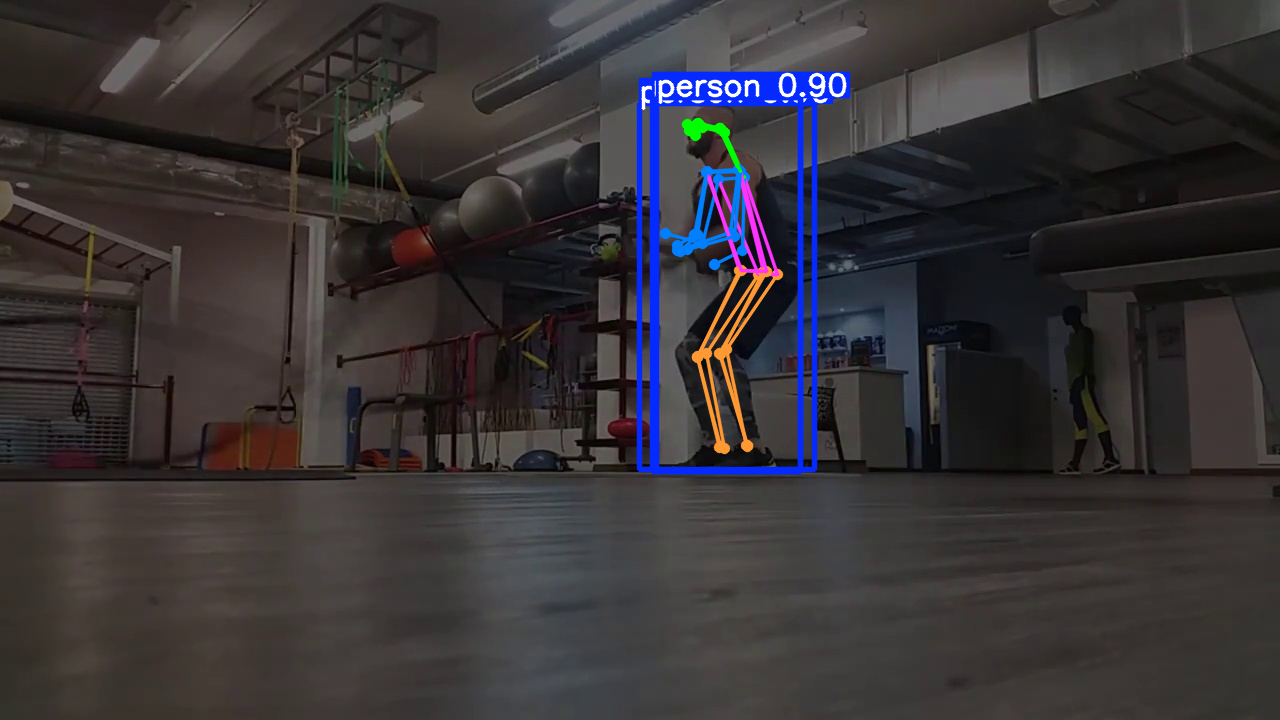

In [31]:
# Visualize the result and get the resized image

pil_image = Image.open(frame_file.get_path())

if not frame_annotations[0][2].is_detected:
    im_rgb = pil_image
else: 
    # Convert RGB to BGR
    rgb_array = np.asarray(pil_image)
    
    if rgb_array.ndim == 3 and rgb_array.shape[2] == 3:
        bgr_array = rgb_array[:, :, ::-1]
    else:
        # If the image is not RGB (e.g., grayscale or RGBA), return as is
        bgr_array = rgb_array
    
    r = ur.engine.results.Results(
        bgr_array,
        path=frame_file.get_path(),
        names={0: 'person'},
        boxes=boxes.data,
        keypoints=keypoints.data,
    )


visualize_ultralytics_results(r, scale=1)

## Visualize frames for a list of `video_id` 

Let's adapt this algorithm to visualize pose detections for list of `video_id` 

In [41]:
from src.ultralitics_utils import fetch_frame_ids, process_frame2results

In [45]:
def plot_results(dc, video_ids, conf=0.5, top_k=10,  cols=4, figsize=(15, 3)):
    """Plot the detection results for all videos in a subplot grid."""
    
    # Calculate total frames to plot and rows needed
    total_frames = top_k * len(video_ids)
    rows = total_frames // cols + (total_frames % cols > 0)
    
    # Create a figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], rows * figsize[1]))
    axes = axes.flatten()  # Flatten axes for easy iteration

    idx = 0  # Track subplot index
    for vid in video_ids:

        # Select Detections with confidence >= "conf" and show top_k only
        dc_pose = (
            dc
            .filter(C("frame.video_id") == vid)
            .filter(C("pose.confidence") >= conf)
            .order_by("frame.frame_id", descending=False)
            .limit(top_k)   
            .save()  # Need to apply this filter
        )

        # Extract frame IDs selected in "dc_pose"
        frame_ids = fetch_frame_ids(dc_pose)

        # Show all Detections for each selected frames
        for fid in frame_ids:
            
            if idx >= axes.size:
                print(f"Reached subplot limit. Skipping further frames for video {vid}.")
                break

            # Fetch frame annotations and frame image file
            frame_annotations = list(dc_pose.filter(C("frame.frame_id") == fid).collect("file", "frame", "pose"))
            img_file = frame_annotations[0][0]
            pose_detections = [annotation[2] for annotation in frame_annotations]
        
            # Convert Detections into Ultralitics' Results object and get annotated image
            r = process_frame2results(img_file, pose_detections)
            im_rgb = visualize_ultralytics_results(r, scale=1)

            # Plot image in the corresponding subplot
            ax = axes[idx]
            ax.imshow(im_rgb)
            ax.axis('off')  # Hide axes
            ax.set_title(f"{'/'.join(img_file.get_path().split('/')[-2:])}")

            idx += 1  # Move to the next subplot

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


['9Ohpl6l4gEI', 'ADtYZmfgeSM', 'AIF4DmpgrtI']


Saving: 10 rows [00:00, 2976.58 rows/s]
Saving: 10 rows [00:00, 3069.60 rows/s]
Saving: 10 rows [00:00, 2735.30 rows/s]


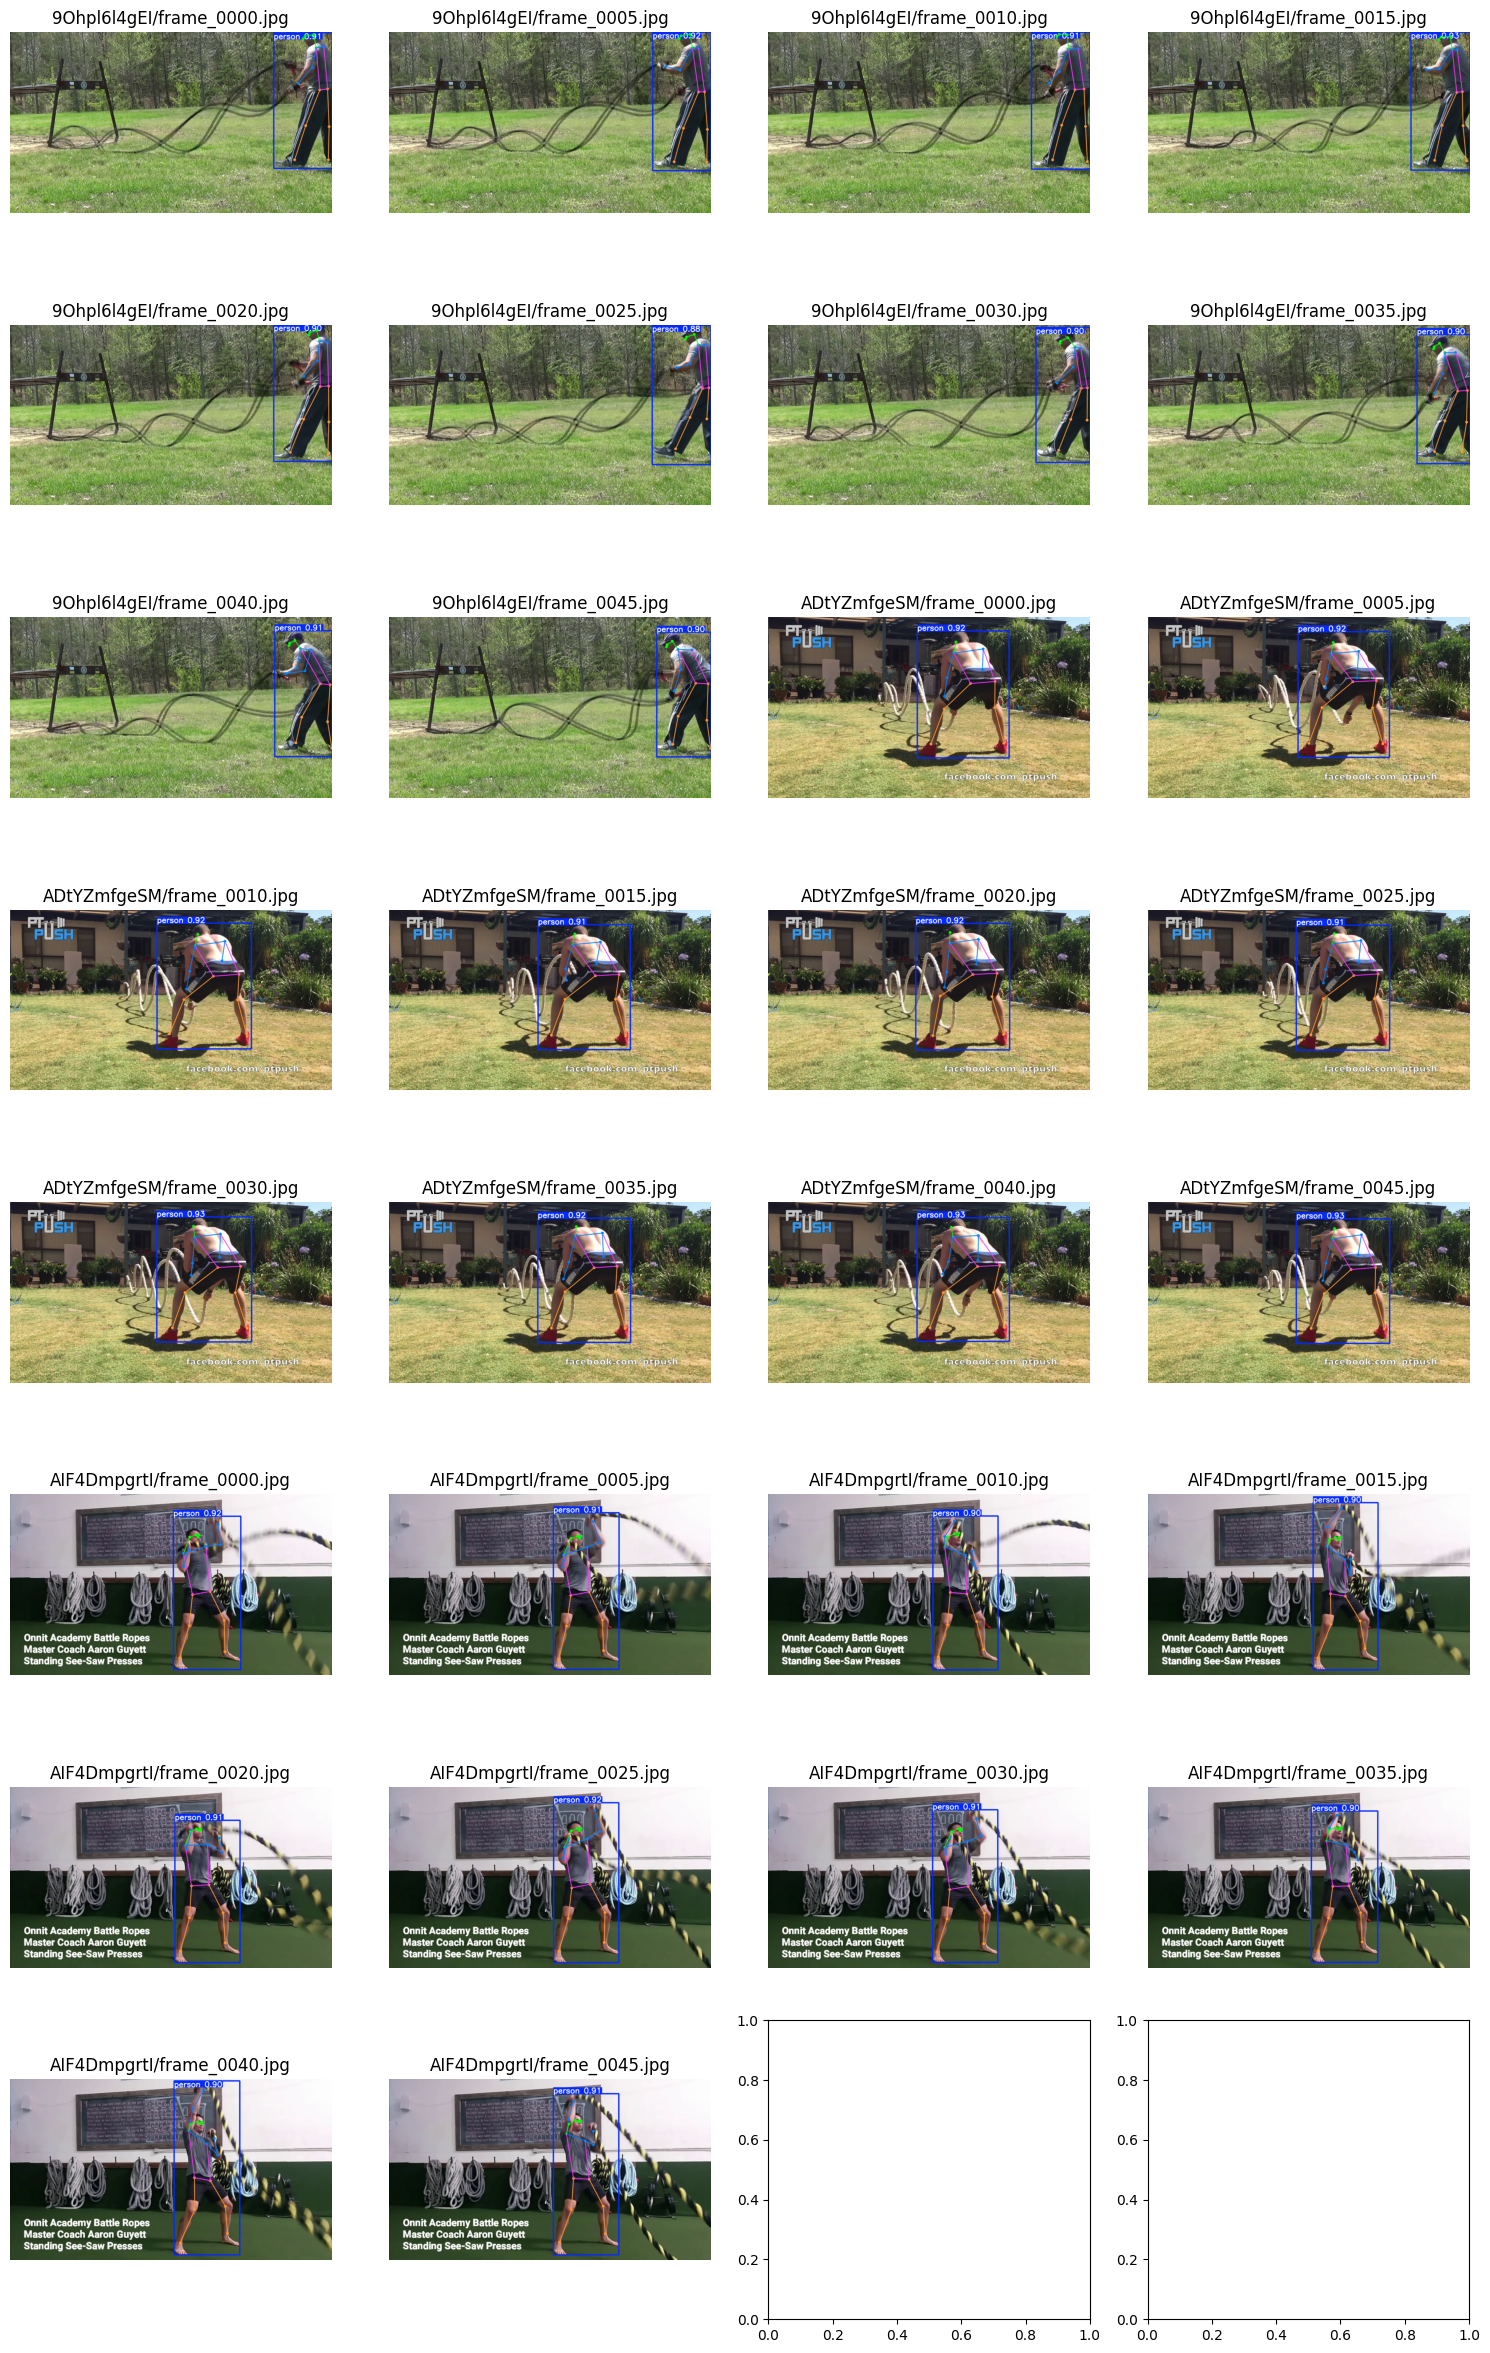

In [46]:
# Example usage
dc_pose = DataChain.from_dataset('k700-top-frames-pose')

video_ids = list(dc_pose.filter(C("pose.confidence") > 0.8).distinct("frame.video_id").collect("frame.video_id"))
print(video_ids)

plot_results(dc_pose, video_ids[:3], top_k=10,  conf=0.8, cols=4, figsize=(15, 3))

# 🎉 Summary 

👏 **Congratulations on completing this tutorial!** 

We are happy to hear about your insights and use case. Please, don't hesitate to share your thoughts and feature requests! 

How to update this into your project? 
1. Design DataModel classes for metadata and annotations
2. Create DataChains for media files and annotations (from cloud buckets, folders, json, csv, etc.)
3. Merge media and annotation DataChains for easy processing and filtering
4. Add utils and visualizations for DataChains.

🤝 **Get Involved**

We'd love to have you join our growing community of DataChain users and contributors! Here's how you can get involved:

- ⭐ Give us a star on [GitHub](https://github.com/iterative/datachain) to show your support
- 🌐 Visit the [datachain.ai website](https://datachain.ai/) to learn more about our products and services
- 📞 Contact us to discuss on scaling 🚀 DataChain for your project!
- 🙌 Follow us on [LinkedIn](https://www.linkedin.com/company/dvc-ai/) and [Twitter](https://x.com/DVCorg) for the latest updates and insights

Thanks for choosing DataChain, and happy coding! 😄